# Section 1: Business Understanding
In the year 2020 the Coronavirus swept the globe. The disease has been detected in more than 200 countries, and there are over 5 million reported cases.

In this project we will explore how the pandemic affected Scotland, and attempt to answer the following questions:
- Has Scotland passed the peak?
- Are areas of deprivation more impacted by Coronavirus?
- Which areas have been most affected and why?


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import seaborn as sns

# Section 2: Data Understanding

In this section we will:
- Gather the data we need to answer the questions
- Clean the data so that it can be loaded and assessed
- Assess the data to decide which columns will be helpful


### Section 2.1: Gather and assess the data for deaths per week

Firstly we will use the 'Deaths By Health Board, Age and Sex' dataset from opendata.nhs.scot to help us answer the first question: Has Scotland passed the peak?. Let's take a look at our columns and decide which are going to be useful.

| Column Name | Type | Description | Needed? | Reason |
|:------------|:-----|:------------|:--------|:-------|
| WeekEnding  | Numeric | Last day of the week during which the death was registered | Yes | We need the dates to know when the death occured |
| HB          | Text | Health Board 2019 | No | Not needed to answer any of the questions we have posed
| HBQF        | Text | Qualifier for Health board | No | Not needed to answer any of the questions we have posed
| AgeGroup    |	Text | Age group of patient | Yes | While this is not needed to answer any of the questions, we do need to group by the age to filter out duplicate records. This is because the dataset has 3 age-related records for each week: 1 for over 65s, 1 for under 65s, and 1 combining both. We are only interested in the row combining both (i.e. the aggregate) |
| AgeGroupQF  | Text | Qualifier for AgeGroup, indicating aggregated data | Yes | As before, this is not needed to answer any of the questions, but will allow us to filter to only show the aggregated age data |
| Sex         |	Text | Sex of patient | Yes | Like with the Age columns, this is not needed to answer any of the questions, but is needed to filter out duplicate records. This is because the dataset has 3 sex-related records for each week: 1 for male, 1 for female, and 1 combining both. We are only interested in the row combining both (i.e. the aggregate) |
| SexQF       | Text | Qualifier for Sex, indicating aggregated data | Yes | As before, this is not needed to answer any of the questions, but will allow us to filter to only show the aggregated sex data |
| Deaths        | Numeric | Weekly number of deaths from all causes | Yes | This is the primary measure we will be using to answer the first two questions |
| Average20152019 | Numeric | Average weekly number of deaths in 2015-2019 | Yes | We will use this data to compare the year 2020 to previous years |
| PercentVariation | Numeric | Variation in the number of deaths from the 2015-2019 average | No | Not needed to answer any of the questions we have posed |
| PercentVariationQF | Text | Qualifier for PercentVariation | No | Not needed to answer any of the questions we have posed |

In [2]:
#Load data
deaths_age_sex_csv = 'https://www.opendata.nhs.scot/dataset/5a9ecd07-fcd0-433c-94be-771eb4e0a691/resource/733aad2d-5420-4966-bc34-386a3475623f/download/deaths_hb_agesex_21072020.csv'

#Output files
monthly_deaths_png = '.\\Graphs\\monthly-deaths.png'

#Function to load data
def load_data(csv_path, columns, skiprows, nrows):
    '''
    This function loads data from a CSV into a dataframe, and performs some basic cleaning
    
    Parameters:
    csv_path: the csv containing the data
    columns: the columns to be included
    skiprows: line numbers to skip (0-indexed) or number of lines to skip (int) at the start of the file.
    nrows: number of rows of file to read

    Returns:
    df: a dataframe containing the loaded data
    '''

    #Load CSV
    df = pd.read_csv(csv_path, skiprows=skiprows, nrows=nrows, thousands=',')

    #Limit df to only the specified columns
    df = df[columns]

    #Remove rows if all of the values are blank i.e. an empty row
    df.dropna(how="all", inplace=True)

    return df

#Load data into dataframe
df = load_data(deaths_age_sex_csv, ['WeekEnding', 'AgeGroup', 'AgeGroupQF', 'Sex', 'SexQF',
       'Deaths', 'Average20152019'], None, None)
df = df[(df['AgeGroupQF'] == 'd') & (df['SexQF'] == 'd')]

#Investigate the data
print(df.head())


    WeekEnding  AgeGroup AgeGroupQF  Sex SexQF  Deaths  Average20152019
2     20200105  All ages          d  All     d     105             98.0
7     20200105  All ages          d  All     d      19             29.0
12    20200105  All ages          d  All     d      37             41.8
17    20200105  All ages          d  All     d      76             72.4
22    20200105  All ages          d  All     d     112            127.2


### Section 2.2: Gather and assess the data for deaths by deprivation

We will use the 'Deaths By Deprivation' dataset from opendata.nhs.scot to help us answer the second question: Are areas of deprivation more impacted by Coronavirus?.

In the Deaths By SIMD (Scottish Index of Multiple Deprivation) csv we will again exclude the columns for HealthBoard and Percentage Variation.

In [3]:
#Load data
deaths_hb_simd_csv = 'https://www.opendata.nhs.scot/dataset/5a9ecd07-fcd0-433c-94be-771eb4e0a691/resource/98648584-4a34-4374-832c-d3f50b6edd80/download/deaths_hb_simd_21072020.csv'

#Output files
deaths_by_simd_png = '.\\Graphs\\deaths-by-simd.png'

#Load data into dataframe
df_simd = load_data(deaths_hb_simd_csv, ['WeekEnding', 'SIMDQuintile',
       'Deaths', 'Average20152019'], None, None)
pd.read_csv(deaths_hb_simd_csv)

#Investigate the data
print(df_simd.head())

   WeekEnding  SIMDQuintile  Deaths  Average20152019
0    20200105             1     283            306.4
1    20200105             2     258            290.6
2    20200105             3     253            271.4
3    20200105             4     212            222.6
4    20200105             5     151            181.4


### Section 2.3: Gather and assess the data for cases by Population Density, and Land Area

We will use a further three datasets to answer our third question: Which areas have been most affected and why?

Firstly let's take a look at a dataset from opendata.nhs.scot that shows the number of cases. It contains a number of columns, but we are only interested in the first three: 'CA' (i.e. the Council Area),'CumulativePositive' (i.e. the total number of positive coronavirus cases), and 'CumulativeDeaths' (i.e. the total number of deaths due to coronavirus).

In [4]:
#Load data
cases_ca = 'https://www.opendata.nhs.scot/dataset/b318bddf-a4dc-4262-971f-0ba329e09b87/resource/427f9a25-db22-4014-a3bc-893b68243055/download/trend_ca_20200809.csv'

#Output files
cases_by_area_png = '.\\Graphs\\cases-by-area.png'
cases_by_area_labelled_png = '.\\Graphs\\cases-by-area-labelled.png'

#Load data into dataframes
df_cases = load_data(cases_ca, ['CA','CumulativePositive','CumulativeDeaths'], None, None)
df_cases_pivot = df_cases.groupby(['CA']).max()

print(df_cases.head())

          CA  CumulativePositive  CumulativeDeaths
0  S12000005                   0                 0
1  S12000006                   0                 0
2  S12000008                   0                 0
3  S12000010                   0                 0
4  S12000011                   0                 0


To investigate population density, we will use the 'Population Estimation' csv from nrscotland.gov.uk.

This dataset contains population information for every year from 1981 - 2019, but we are only interested in the most up-to-date popualtion estimates, so in this case we will keep the following columns: 'Code' (i.e. the council area code), 'Persons' (i.e. the council area description), and '2019' (i.e. the population in 2019). These column names are not the most descriptive, so we will change them for consistency and clarity.

Some additional cleansing is needed to this csv file, as there are a number of unnecessary rows at the top and bottom of the file. We will only load the rows that we need by using the load_data function's skiprows and nrows parameters. This function also drops rows that contain no data whatsoever, which is critical for this file as there are numerous empty rows.


In [5]:
#Load data
pop_density_ca = '.\\Data\\mid-year-pop-est-19-time-series-2_1981-2019.csv'

#Load data into dataframes
df_popdensity = load_data(pop_density_ca, ['Code','Persons','2019'], skiprows = 2, nrows=35)
df_popdensity.rename(columns={"Persons": "CouncilArea", "Code": "CA", "2019": "PopDensity"}, inplace=True)

print(df_popdensity.head())

          CA      CouncilArea  PopDensity
1  S92000003         Scotland   5463300.0
2  S12000033    Aberdeen City    228670.0
3  S12000034    Aberdeenshire    261210.0
4  S12000041            Angus    116200.0
5  S12000035  Argyll and Bute     85870.0


To investigate land area, we will use the 'Land Area' csv from statistics.gov.scot.

Again, we are only interested in a few of the columns, in this case: 'FeatureCode' (i.e. the council area code) and Value (i.e. the land area in hectares). Again we will rename the columns for consistency and clarity.

In [6]:
#Load data
land_area_ca = '.\\Data\\land_area_ca_2014.csv'

#Load data into dataframea
df_landarea = load_data(land_area_ca, ['FeatureCode','Value'], None, None)
df_landarea.rename(columns={"FeatureCode": "CA", "Value": "LandArea"}, inplace=True)

print(df_landarea.head())

          CA    LandArea
0  S13002516   23827.131
1  S13002517  177176.224
2  S13002518   79837.075
3  S13002519  109224.886
4  S13002520  156589.083


# Section 3: Data Preparation

In this section we will:

- Prepare the data so that it is in a format that can be analysed and visualised

### Section 3.1: Preparing the data for deaths per week

When looking at the data, it would be helpful to see it grouped by month. Let's add extra columns with date information to the first dataframe.

In [7]:
#Add Columns for more date data
formatted_dates_list = []
months_list = []
for ymd in df['WeekEnding']:
    formatted_date = datetime.strptime(str(ymd), '%Y%m%d').strftime('%m/%d/%Y')
    month = datetime.strptime(str(ymd), '%Y%m%d').strftime('%B')
    formatted_dates_list.append(formatted_date)
    months_list.append(month)
df['Formatted Date'] = formatted_dates_list
df['Month'] = months_list

print(df.head())

    WeekEnding  AgeGroup AgeGroupQF  Sex SexQF  Deaths  Average20152019  \
2     20200105  All ages          d  All     d     105             98.0   
7     20200105  All ages          d  All     d      19             29.0   
12    20200105  All ages          d  All     d      37             41.8   
17    20200105  All ages          d  All     d      76             72.4   
22    20200105  All ages          d  All     d     112            127.2   

   Formatted Date    Month  
2      01/05/2020  January  
7      01/05/2020  January  
12     01/05/2020  January  
17     01/05/2020  January  
22     01/05/2020  January  


And now let's group the data so that we can see the deaths per week in 2020, and the average number of deaths per week in the years prior.

In [8]:
#Show the number of deaths per week
df = df.groupby(['WeekEnding','Month'])[['Deaths','Average20152019']].sum().reset_index()
df['WeekEnding'] = pd.to_datetime(df['WeekEnding'], format='%Y%m%d')

print(df.head())

  WeekEnding     Month  Deaths  Average20152019
0 2020-01-05   January    2318           2548.4
1 2020-01-12   January    3126           3114.0
2 2020-01-19   January    2638           2760.8
3 2020-01-26   January    2447           2629.6
4 2020-02-02  February    2373           2556.2


### Section 3.2: Preparing the data for deaths by deprivation

For the SIMD dataframe, we want to create a pivot chart so that we can see the number of deaths per SIMD index, grouped by week.

In [9]:
df_simd['WeekEnding'] = pd.to_datetime(df_simd['WeekEnding'], format='%Y%m%d')
df_simd = df_simd.pivot_table(index='WeekEnding',columns='SIMDQuintile')['Deaths']

print(df_simd.head())

SIMDQuintile    1    2    3    4    5
WeekEnding                           
2020-01-05    283  258  253  212  151
2020-01-12    384  360  330  281  204
2020-01-19    313  301  273  251  178
2020-01-26    325  262  247  215  172
2020-02-02    276  281  249  195  184


### Section 3.3: Preparing the data for cases by population density, and land area

Let's bring all three data frames for the third question togather into a single dataframe.

In [10]:
#Combine into one dataframe
df_combined_pd = pd.merge(df_popdensity, df_cases_pivot, on='CA')
df_combined_pd = pd.merge(df_combined_pd, df_landarea, on='CA')

print(df_combined_pd.head())

          CA        CouncilArea  PopDensity  CumulativePositive  \
0  S12000033      Aberdeen City    228670.0                1097   
1  S12000034      Aberdeenshire    261210.0                 596   
2  S12000041              Angus    116200.0                 474   
3  S12000035    Argyll and Bute     85870.0                 169   
4  S12000036  City of Edinburgh    524930.0                1848   

   CumulativeDeaths    LandArea  
0                78   18570.629  
1                58  631260.885  
2                46  218178.547  
3                35  690946.621  
4               263   26333.391  


# Section 4: Evaluate the Results

In this section we will:

- Visualise and analysed the data
- Draw conclusions based on the data

### Section 4.1: Has Scotland passed the peak?

Let's take a look at the number of deaths in 2020, v the number of deaths in the years prior to 2020.

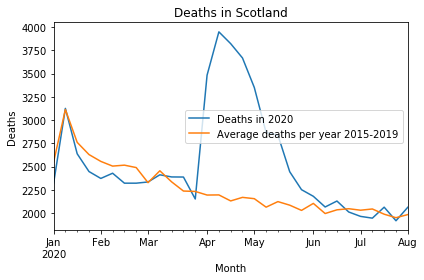

In [11]:
#Plot graph showing deaths in 2020 against deaths over the last 4 years
ax = df.plot(x='WeekEnding',y=['Deaths','Average20152019'])
ax.set(xlabel='Month', ylabel='Deaths')
plt.title('Deaths in Scotland')
ax.legend(["Deaths in 2020", "Average deaths per year 2015-2019"]);
plt.tight_layout()
ax.figure.savefig(monthly_deaths_png)


In the graph above we can see a clear peak at the beginning of April, followed by a decline. This implies that we are indeed past the peak.

### Section 4.2: Are areas of deprivation more impacted by Coronavirus?

This time we will plot the number of deaths per week, but with one line per SIMD quintile.

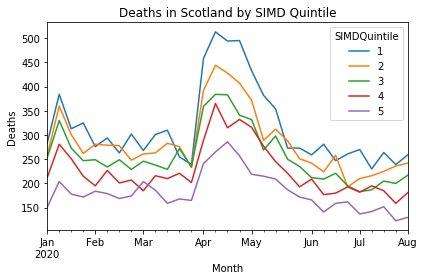

In [12]:
#Plot a graph showing the number of deaths in 2020 by SIMD
ax = df_simd.plot()
ax.set(xlabel='Month', ylabel='Deaths')
plt.title('Deaths in Scotland by SIMD Quintile')
plt.tight_layout()
ax.figure.savefig(deaths_by_simd_png)


In the graph above we can that the number of deaths appears to be directly proportional to the SIMD quintile. This implies that that areas of deprivation are more impacted by Coronavirus.

It is also worth noting that the same correlation holds even in January, when the deaths were not likely to be caused by the Coronavirus. This means that those in a low SIMD quintile are at a higher risk of death than those in less deprived areas.

### Section 4.3: Which areas have been most affected and why?

Let's take a look at the number of cases by population density. On this graph we can see:
- The number of cases by council area on the x-axis
- The population density by council area on the y-axis

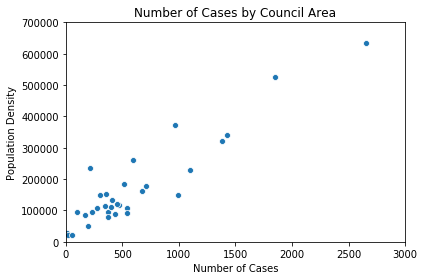

In [13]:
ax1 = sns.scatterplot(x='CumulativePositive', y='PopDensity', data=df_combined_pd, legend=False)#, hue='CouncilArea', alpha=0.6
ax1.set(ylim=(0, 700000),xlim=(0, 3000),xlabel='Number of Cases', ylabel='Population Density')
plt.title('Number of Cases by Council Area')
plt.tight_layout()

This shows a correlation between the number of cases, and the population density of an area. 

But what about the size of the area? Let's re-plot this graph as a bubble graph, with the land area of the council area represented by the size of the bubble.

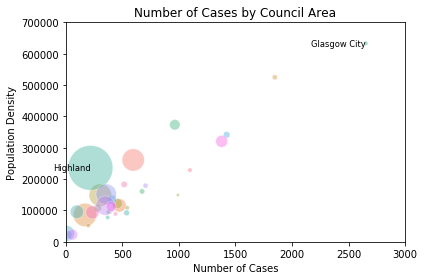

In [14]:
#Plot a bubble diagram, with labels to show Glasgow and Highlands
ax2 = sns.scatterplot(x='CumulativePositive', y='PopDensity', data=df_combined_pd, size='LandArea', hue='CouncilArea', sizes=(10, 2000), alpha=0.4, legend=False)
ax2.set(ylim=(0, 700000),xlim=(0, 3000),xlabel='Number of Cases', ylabel='Population Density')
plt.title('Number of Cases by Council Area')
plt.tight_layout()
for line in df_combined_pd.index:
    if (df_combined_pd.CouncilArea[line] == 'Glasgow City' or df_combined_pd.CouncilArea[line] == 'Highland'):
        ax2.text(df_combined_pd.CumulativePositive[line], df_combined_pd.PopDensity[line], df_combined_pd.CouncilArea[line], ha='right', va='center', size='small', color='black')

Let's take a further look at Land Area by exploring the difference between the records for Glasgow City and The Highlands

In [15]:
#Drilling down into the records for Glasgow v Highlands
df_GLA_HIG = df_combined_pd[['CouncilArea','CumulativePositive', 'PopDensity', 'LandArea']]
df_GLA_HIG = df_GLA_HIG.loc[(df_GLA_HIG['CouncilArea'] == 'Glasgow City') | (df_GLA_HIG['CouncilArea'] == 'Highland')]
print(df_GLA_HIG)

     CouncilArea  CumulativePositive  PopDensity     LandArea
14  Glasgow City                2653    633120.0    17467.557
15      Highland                 218    235830.0  2568388.607


This shows that there is not a relationship between the size of an area, and the number of coronavirus cases.

## Conclusion

From looking at the data we have concluded that:
- The peak number of deaths in Scotland happened in April.
- The more deprived an area is, the more people are likely to die of coronavirus.
- There are considerably more cases in densely populated areas than in sparsely populated areas.
- There is no correlation between the land area of a concil area, and the number of cases.